##### Copyright 2024 Google LLC.

In [ ]:
#@title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# Gemini API: Model tuning with Python

<table class="tfo-notebook-buttons" align="left">
  <td>
    <a target="_blank" href="https://ai.google.dev/gemini-api/docs/model-tuning/python"><img src="https://ai.google.dev/static/site-assets/images/docs/notebook-site-button.png" height="32" width="32" />View on ai.google.dev</a>
  </td>
    <td>
    <a target="_blank" href="https://colab.research.google.com/github/google/generative-ai-docs/blob/main/site/en/gemini-api/docs/model-tuning/python.ipynb"><img src="https://www.tensorflow.org/images/colab_logo_32px.png" />Run in Google Colab</a>
  </td>
  <td>
    <a target="_blank" href="https://github.com/google/generative-ai-docs/blob/main/site/en/gemini-api/docs/model-tuning/python.ipynb"><img src="https://www.tensorflow.org/images/GitHub-Mark-32px.png" />View source on GitHub</a>
  </td>
</table>

In this notebook, you'll learn how to get started with the tuning service using the Python client library for the Gemini API. Here, you'll learn how to tune the text model behind the Gemini API's text generation service.

## Setup

### Install the client library

In [141]:
!pip install -q google-generativeai

### Import libraries

In [142]:
import google.generativeai as genai

In [143]:
from google.colab import userdata
genai.configure(api_key=userdata.get('GOOGLE_API_KEY'))

You can check you existing tuned models with the `genai.list_tuned_model` method.

In [144]:
for i, m in zip(range(5), genai.list_tuned_models()):
  print(m.name)

tunedModels/generate-ner-1


## Create tuned model

To create a tuned model, you need to pass your dataset to the model in the `genai.create_tuned_model` method. You can do this be directly defining the input and output values in the call or importing from a file into a dataframe to pass to the method.

For this example, you will tune a model to generate the next number in the sequence. For example, if the input is `1`, the model should output `2`. If the input is `one hundred`, the output should be `one hundred one`.

In [63]:
base_model = [
    m for m in genai.list_models()
    if "createTunedModel" in m.supported_generation_methods and
    "flash" in m.name][0]
base_model

Model(name='models/gemini-1.5-flash-001-tuning',
      base_model_id='',
      version='001',
      display_name='Gemini 1.5 Flash 001 Tuning',
      description=('Version of Gemini 1.5 Flash that supports tuning, our fast and versatile '
                   'multimodal model for scaling across diverse tasks, released in May of 2024.'),
      input_token_limit=16384,
      output_token_limit=8192,
      supported_generation_methods=['generateContent', 'countTokens', 'createTunedModel'],
      temperature=1.0,
      max_temperature=2.0,
      top_p=0.95,
      top_k=64)

In [58]:
##read in csv file and parse text_input and output pairs to feed into the "training data" object
#Training data has a format where each input_output pair is a dict with key text_input and key output, values are the actual ones
#Need to essentially have n=45 dictionaries
import pandas as pd
import ast

training_data_ner = []

train_df = pd.read_csv("train_ner_finetune.csv")

for i in range(len(train_df)):
  drugs_str = train_df['drugs'].iloc[i]
  note = train_df['meds_section'].iloc[i]
  temp_dict = {
             'text_input': note,
             'output': drugs_str,
        }
  training_data_ner.append(temp_dict)







3765


In [65]:
name = 'generate-ner-1'
operation = genai.create_tuned_model(
    # You can use a tuned model here too. Set `source_model="tunedModels/..."`
    source_model=base_model.name,
    training_data=training_data_ner,
    id = name,
    epoch_count = 100,
    batch_size=4,
    learning_rate=0.001,
)

Your tuned model is immediately added to the list of tuned models, but its status is set to "creating" while the model is tuned.

In [145]:
model = genai.get_tuned_model(f'tunedModels/{name}')

model

TunedModel(name='tunedModels/generate-ner-1',
           source_model='models/gemini-1.5-flash-001-tuning',
           base_model='models/gemini-1.5-flash-001-tuning',
           display_name='',
           description='',
           temperature=1.0,
           top_p=0.95,
           top_k=64,
           state=<State.ACTIVE: 2>,
           create_time=datetime.datetime(2025, 4, 28, 17, 40, 58, 155928, tzinfo=datetime.timezone.utc),
           update_time=datetime.datetime(2025, 4, 28, 18, 21, 28, 622738, tzinfo=datetime.timezone.utc),
           tuning_task=TuningTask(start_time=datetime.datetime(2025, 4, 28, 17, 40, 59, 318890, tzinfo=datetime.timezone.utc),
                                  complete_time=datetime.datetime(2025, 4, 28, 18, 21, 28, 622738, tzinfo=datetime.timezone.utc),
                                  snapshots=[...],
                                  hyperparameters=Hyperparameters(epoch_count=100,
                                                                  ba

In [67]:
model.state

<State.CREATING: 1>

### Check tuning progress

Use `metadata` to check the state:

In [140]:
operation.name

'tunedModels/generate-ner-1/operations/nqgn5wbljcxn'

Wait for the training to finish using `operation.result()`, or `operation.wait_bar()`

In [69]:
import time

for status in operation.wait_bar():
  time.sleep(30)

  0%|          | 0/1025 [00:00<?, ?it/s]

You can cancel your tuning job any time using the `cancel()` method. Uncomment the line below and run the code cell to cancel your job before it finishes.

In [ ]:
# operation.cancel()

Once the tuning is complete, you can view the loss curve from the tuning results. The [loss curve](https://ai.google.dev/gemini-api/docs/model-tuning#recommended_configurations) shows how much the model's predictions deviate from the ideal outputs.

<Axes: xlabel='epoch', ylabel='mean_loss'>

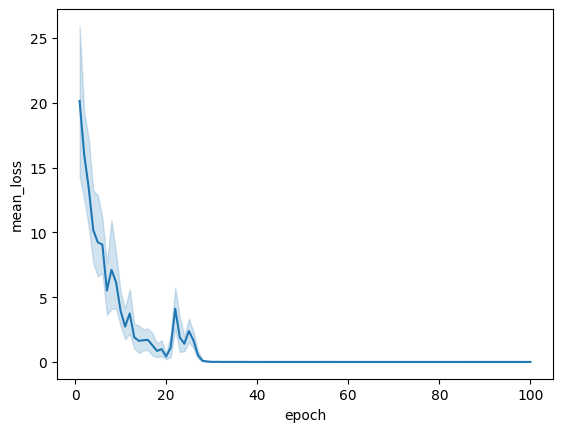

In [70]:
import pandas as pd
import seaborn as sns

model = operation.result()

snapshots = pd.DataFrame(model.tuning_task.snapshots)

sns.lineplot(data=snapshots, x = 'epoch', y='mean_loss')


## Evaluate your model

You can use the `genai.generate_content` method and specify the name of your model to test your model performance.

In [72]:
model = genai.GenerativeModel(model_name=f'tunedModels/{name}')
test_df = pd.read_csv('test_ner_finetune.csv')

In [137]:

result = model.generate_content(test_df['meds_section'].iloc[4], safety_settings=[
        {
            "category": "HARM_CATEGORY_DANGEROUS_CONTENT",
            "threshold": "HIGH",  # Allow 'medium' but block at 'high'
        },
        {
            "category": "HARM_CATEGORY_HATE_SPEECH",
            "threshold": "HIGH",
        },
        {
            "category": "HARM_CATEGORY_SEXUALLY_EXPLICIT",
            "threshold": "HIGH",
        },
        {
            "category": "HARM_CATEGORY_HARASSMENT",
            "threshold": "HIGH",
        },
    ])

In [138]:
import ast
predicted_drugs = result.text
index = predicted_drugs.find('[')
predicted_drugs = predicted_drugs[index:]

predicted_drugs_list = ast.literal_eval(predicted_drugs)

true_drugs_list = ast.literal_eval(test_df['drugs'].iloc[4])

def proportion_overlap(set1, set2):
    """
    Compute the proportion of elements in set1 that exist in set2 (case insensitive).

    Args:
        set1 (iterable): First set/list of elements.
        set2 (iterable): Second set/list of elements.

    Returns:
        float: Proportion of set1 elements that are found in set2.
    """
    # Normalize everything to strings, lowercase, and strip
    set1 = {str(e).lower().strip() for e in set1}
    set2 = {str(e).lower().strip() for e in set2}

    if len(set1) == 0:
        return 0.0  # Avoid division by zero

    # Find intersection
    intersection = set1 & set2

    # Calculate proportion
    return len(intersection) / len(set1)

print(proportion_overlap(predicted_drugs_list, true_drugs_list))
print(predicted_drugs_list)


0.8888888888888888
['Warfarin', 'Acetaminophen', 'Lisinopril', 'Metoprolol Tartrate', 'Simvastatin', 'Levothyroxine Sodium', 'Torsemide', 'Calcitriol', 'Glargine']


In [31]:
result = model.generate_content('123455')
result.text

'123455'

In [32]:
result = model.generate_content('four')
result.text

'four'

In [33]:
result = model.generate_content('quatre') # French 4
result.text                               # French 5 is "cinq"

'quatre'

In [34]:
result = model.generate_content('III')    # Roman numeral 3
result.text                               # Roman numeral 4 is IV

'III'

In [35]:
result = model.generate_content('七')  # Japanese 7
result.text                            # Japanese 8 is 八!

'七'

It really seems to have picked up the task despite the limited examples, but "next" is a simple concept, see the [tuning guide](https://ai.google.dev/gemini-api/docs/model-tuning) for more guidance on improving performance.

Now, we have done the NER task and fine-tuning for that. We will use this NER model as our base now and try for relational NER with the tuple format, and a specific prompt to ensure the model tries to capture relational information. Let's give it the whole note and see how it performs fine-tuning wise.

In [151]:
training_data_relational_ner = [] #the final array of training data

prompt_begin = """
For each medication I want you to relational named entity recognition, and extract the following fields from the given clinical note as it relates to each drug:
- "Drug Name": The free-text name of the drug mentioned.
- "Drug Dosage": The prescribed amount (if explicitly stated); otherwise, "Not mentioned."
- "Unit of Measurement of Dosage": The unit (e.g., mg, mL) (if stated); otherwise, "Not mentioned."
- "Drug Form": The formulation (e.g., Tablet, Vial) (if stated); otherwise, "Not mentioned."
- "Route": The route of administration (e.g., PO, IV) (if stated); otherwise, "Not mentioned."

**Important Instructions:**
- If any field is missing in the original note, set its value to "Not mentioned".
- DO NOT add any extra explanation, headers, or text — output ONLY the formatted dictionary as shown in an example below:

{Drug A: [("dose1A", "unit1A", "route1A", "form1A"), ("dose2A", "unit2A", "route2A", "form2A")], Drug B: [("dose1B", "unit1B", "route1B", "form1B")]

This is assuming there are two unique and unrelated mentions of drug A (not in the same context), and only one contextual mention of Drug B. This is the note: \n

"""

train_relational_finetune_df = pd.read_csv("train_relational_finetune.csv")

for i in range(len(train_relational_finetune_df)):
  prompt = prompt_begin + train_relational_finetune_df['text'].iloc[i]
  expected_output = train_relational_finetune_df['meds_section_gt'].iloc[i]
  training_data_relational_ner.append(
      {
          'text_input': prompt,
          'output': expected_output
      }
  )

print(len(training_data_relational_ner))

name = 'generate-relationalner-1'
operation = genai.create_tuned_model(
    # You can use a tuned model here too. Set `source_model="tunedModels/..."`
    source_model="tunedModels/generate-ner-1",
    training_data=training_data_relational_ner,
    id = name,
    epoch_count = 100,
    batch_size=4,
    learning_rate=0.001,
)

41


In [152]:
model = genai.get_tuned_model(f'tunedModels/{name}')
model.state

<State.CREATING: 1>

In [153]:
operation.name

'tunedModels/generate-relationalner-1/operations/ztbq7rdj8utj'

In [154]:
import time

for status in operation.wait_bar():
  time.sleep(30)

  0%|          | 0/1025 [00:00<?, ?it/s]

In [ ]:
#Model has been fine-tuned; include methods

## Update the description

You can update the description of your tuned model any time using the `genai.update_tuned_model` method.

In [ ]:
genai.update_tuned_model(f'tunedModels/{name}', {"description":"This is my model."});

In [ ]:
model = genai.get_tuned_model(f'tunedModels/{name}')

model.description

'This is my model.'

## Delete the model

You can clean up your tuned model list by deleting models you no longer need. Use the `genai.delete_tuned_model` method to delete a model. If you canceled any tuning jobs, you may want to delete those as their performance may be unpredictable.

In [36]:
genai.delete_tuned_model(f'tunedModels/{name}')

The model no longer exists:

In [37]:
try:
  m = genai.get_tuned_model(f'tunedModels/{name}')
  print(m)
except Exception as e:
  print(f"{type(e)}: {e}")

<class 'google.api_core.exceptions.NotFound'>: 404 GET https://generativelanguage.googleapis.com/v1beta/tunedModels/generate-num-588?%24alt=json%3Benum-encoding%3Dint: Tuned model tunedModels/generate-num-588 does not exist.
